In [28]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Type
from torch import nn
from torch.optim import optimizer
import rasterio
import zipfile
from matplotlib import pyplot as plt
import datetime
from torchvision import transforms as transforms
import shutil
import torchmetrics
import os
import pytorch_lightning as pl
import sklearn
from torch.nn import functional as F

# --- GPU selection --- #
gpus = 7 # slot number (e.g., 3), no gpu use -> write just ' '
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=str(gpus)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [29]:
def minmax(array : Type[np.ndarray], dim = 0):
    min = np.min(array, axis=dim)
    max = np.max(array, axis=dim)
    array = (array-min)/(max-min)
    return array

def log_minmax(array : Type[np.ndarray], dim = 0):
    min = np.min(array, axis=dim)
    array = array - min + 1
    array = np.log(array)
    max = np.max(array, axis=dim)
    array = (array)/(max)
    return array

In [49]:
def save_result(model: Type[nn.Module], dataloader : Type[DataLoader], path:str, description:str = '', reference_data:str = '', patch_size:int = 60, now = datetime.datetime.now()):
    best_model = model
    os.makedirs(os.path.join(path,f'{now.year}.{now.month}.{now.day}/', f'{description}/','tmp/'), exist_ok=True)
    zipped_results = zipfile.ZipFile(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','RESULT_{0:0=2d}:{1:0=2d}'.format(now.hour, now.minute)+f'_{description}.zip'), 'w')
    prediction = np.zeros((60,60,7))
    for i, (data, index) in enumerate(dataloader):
        prediction[i, :, :] = best_model(data).detach().numpy()
    prediction_expanded = np.zeros((7,2400,2400))
    for i in range(60):
        for j in range(60):
            for k in range(7):
                prediction_expanded[k,i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = prediction[i,j,k]

    reference_image = rasterio.open(reference_data)
    layer_index = [1,2,7,8,9,10,11]

    for i in range(prediction_expanded.shape[0]):
        print('a') 
        processed_tiff = rasterio.open(
            os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/', 'tmp/', f'Result_{layer_index[i]}_{description}.tif'),
            'w',
            driver='GTiff',
            height=prediction_expanded.shape[1],
            width=prediction_expanded.shape[2],
            count=1,
            dtype=prediction_expanded.dtype,
            crs=reference_image.crs,
            transform=reference_image.transform,
        )
        print('b')
        processed_tiff.write(prediction_expanded[i,:,:],1)
        processed_tiff.close()
        print('c')
        zipped_results.write(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/', 'tmp/', f'Result_{layer_index[i]}_{description}.tif'), f'Result_{layer_index[i]}_{description}.tif')

    zipped_results.close()
    return os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','RESULT_{0:0=2d}:{1:0=2d}'.format(now.hour, now.minute)+f'_{description}.zip')


In [50]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=13, train_rate: float = 0.8, batch_size: int = 60, path:str = '../Data/N12/Model/', description:str = 'no_description', reference_data:str = ''): 
    train_loss_history = []
    valid_loss_history = []

    patch_size = dataloaders['Train'].dataset.data.shape[-1]
    training_patches = len(dataloaders['Train'].dataset)
    validating_patches = len(dataloaders['Validation'].dataset)
    print(f'Training Patches : {training_patches}\nValidating Patches : {validating_patches}')

    best_model_epoch = 0
    least_valid_loss = 100
    now = datetime.datetime.now()
    os.makedirs(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/', 'tmp/'), exist_ok=True)
    zipped_model = zipfile.ZipFile(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/', '{0:0=2d}:{1:0=2d}'.format(now.hour, now.minute)+f'_{description}'+'.zip'), 'w')
    
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        train_running_loss = 0.0
        valid_running_loss = 0.0

        for state in ['Train', 'Validation']:
            for i, (inputs, labels) in enumerate(dataloaders[state]):
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                model.to(device)
                
                outputs = model(inputs)
                
                optimizer.zero_grad()

                if state == 'Train':
                    model.train()
                    train_loss = criterion(outputs, labels)
                    train_loss.backward()
                    train_running_loss += train_loss.item() * inputs.size(0)
                
                if state == 'Validation':
                    model.eval()
                    valid_loss = criterion(outputs, labels)
                    valid_running_loss += valid_loss.item() * inputs.size(0)

                optimizer.step()
                #valid_running_similarity += metric(outputs, labels)
                #print('validating')
                
                #print(f'{i}th batch')
            


        
        #print(f'Memory after a training : {torch.cuda.memory_allocated()/1024/1024}')

        epoch_train_loss = train_running_loss / training_patches
        epoch_valid_loss = valid_running_loss / validating_patches
        scheduler.step(epoch_valid_loss)

        print(f'Valid loss: {epoch_valid_loss} | Train loss: {epoch_train_loss}')


        if epoch_valid_loss < least_valid_loss:
            least_valid_loss = epoch_valid_loss
            best_model_epoch = epoch

        train_loss_history.append(epoch_train_loss)      
        valid_loss_history.append(epoch_valid_loss)

        torch.save(model.state_dict(), os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','tmp/', '{0:0=2d}.pth'.format(epoch)))
        zipped_model.write(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','tmp/', '{0:0=2d}.pth'.format(epoch)))

    plt.figure(figsize=(20,8))
    plt.plot(train_loss_history, 'r-')
    plt.plot(valid_loss_history, 'bo')
    plt.savefig(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','tmp/', 'Tendency.png'), dpi=300)
    zipped_model.write(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','tmp/', 'Tendency.png'))
    zipped_model.writestr('README.txt', f'{description}\nThe best Model : #{best_model_epoch}th model with loss {least_valid_loss}\nOptimizer : {optimizer}\nLoss function : {criterion}\nBatch size : {batch_size}\nScheduler : {scheduler}\nPatch size : {patch_size}\nTotal epochs : {num_epochs}\nModel information :\n{model.modules}')
    
    print('Best loss: {:4f}, in Epoch #{:0=3d}'.format(least_valid_loss, best_model_epoch))    
    zipped_model.close()
    shutil.copy(src=os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/', 'tmp/', '{0:0=2d}.pth'.format(epoch)), dst=os.path.join(path,f'{now.year}.{now.month}.{now.day}/', 'Best_Model_Parameters_of_{0:0=2d}:{1:0=2d}'.format(now.hour, now.minute)+f'_{description}'+'.pth'))
    print('Model information is saved in '+os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/', '{0:0=2d}:{1:0=2d}'.format(now.hour, now.minute)+f'_{description}'+'.zip'))

    model.load_state_dict(torch.load(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','tmp/', '{0:0=2d}.pth'.format(best_model_epoch))))
    result_path = save_result(model = model.to('cpu'), dataloader=dataloaders['Prediction'], path=path, description=description, reference_data=reference_data, patch_size=patch_size, now=now)
    print('Model result is saved in '+ result_path)
    
    shutil.rmtree(os.path.join(path,f'{now.year}.{now.month}.{now.day}/',f'{description}/','tmp/'))
    best_model_path = os.path.join(path,f'{now.year}.{now.month}.{now.day}/', 'Best_Model_Parameters_of_{0:0=2d}:{1:0=2d}'.format(now.hour, now.minute)+f'_{description}'+'.pth')
    return best_model_path

In [34]:
def prepare_raw_files(one_hot_encode:bool = True):
    '''if os.path.exists('../Data/N12/np/train_array.npy') and os.path.exists('../Data/N12/np/target_array_OHE.npy'):
        train_array = np.load('../Data/N12/np/train_array.npy')
        target_array = np.load('../Data/N12/np/target_array_OHE.npy')
    else:'''
    lidar_image = rasterio.open('../Data/N12/N12_lidar.tif').read()
    lidar_array = np.array(lidar_image)
    lidar_array = log_minmax(lidar_array, dim=(0,1))

    lidar_1n_image = rasterio.open('../Data/N12/N12_lidar_1n.tif').read()
    lidar_1n_array = np.array(lidar_1n_image)
    lidar_1n_array = log_minmax(lidar_1n_array, dim=(0,1))

    lidar_nt_image = rasterio.open('../Data/N12/N12_lidar_nt.tif').read()
    lidar_nt_array = np.array(lidar_nt_image)
    lidar_nt_array = log_minmax(lidar_nt_array, dim=(0,1))

    RGB2020_image = rasterio.open('../Data/N12/N12_RGB2020.tif').read()
    RGB2020_array = np.array(RGB2020_image)

    train_array = np.stack([lidar_array, lidar_1n_array, lidar_nt_array]).squeeze()
    train_array = np.concatenate((train_array,RGB2020_array))
    target_image = rasterio.open('../Data/N12/N12_newlc.tif').read()
    target_array = np.array(target_image, dtype=int).squeeze()
    target_array = np.where(target_array == 1, 0, target_array)
    target_array = np.where(target_array == 2, 1, target_array)
    target_array = np.where(target_array == 7, 2, target_array)
    target_array = np.where(target_array == 8, 3, target_array)
    target_array = np.where(target_array == 9, 4, target_array)
    target_array = np.where(target_array == 10, 5, target_array)
    target_array = np.where(target_array == 11, 6, target_array)

    if one_hot_encode:
        num = np.unique(target_array)
        num = num.shape[0]
        encoded_target_array = np.eye(num)[target_array]
        target_array=np.zeros(shape=(7,2400,2400))
        for i in range(encoded_target_array.shape[-1]):
            target_array[i,:,:]=encoded_target_array[:,:,i]

    return train_array, target_array.astype(int)

In [35]:
class TrainDataset2(Dataset):
    def __init__(self, data_array : Type[np.ndarray], target_array : Type[np.ndarray], patch_size : int, is_evaluating : bool = False, is_validating : bool = False, rotate : bool = False, train_ratio : float = 0.8, one_hot_encode:bool = True):
        self.is_validating = is_validating
        self.is_evaluating = is_evaluating
        seed = 386579

        self.data = np.zeros(((data_array.shape[1]//patch_size) * (data_array.shape[2]//patch_size), data_array.shape[0], patch_size, patch_size))

        for i in range(0,data_array.shape[1]//patch_size):
            for j in range(0,data_array.shape[2]//patch_size):
                self.data[data_array.shape[1]//patch_size*i+j,:,:,:] = data_array[:,i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]

        if one_hot_encode:
            self.label = np.zeros(((data_array.shape[1]//patch_size) * (data_array.shape[2]//patch_size), target_array.shape[0] ,patch_size, patch_size), dtype=float)
            for k in range(0,data_array.shape[1]//patch_size):
                for l in range(0,data_array.shape[2]//patch_size):
                    self.label[data_array.shape[1]//patch_size*k+l,:,:,:] = target_array[:,i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
        else:
            self.label = np.zeros(((data_array.shape[1]//patch_size) * (data_array.shape[2]//patch_size),data_array.shape[0]+1))
            for k in range(0,data_array.shape[1]//patch_size):
                for l in range(0,data_array.shape[2]//patch_size):
                    self.label[data_array.shape[1]//patch_size*k+l,:] = np.bincount(target_array[k*patch_size:(k+1)*patch_size, l*patch_size:(l+1)*patch_size].reshape(-1), minlength=7)/(patch_size*patch_size)


        if not is_evaluating:
            if rotate:
                for i in range(2):
                    rotated_data = np.rot90(self.data, k=i+1, axes=(-2, -1))
                    self.data = np.concatenate((self.data, rotated_data), axis=0)
                    if one_hot_encode:
                        rotated_data = np.rot90(self.label, k=i+1, axes=(-2, -1))
                    else:
                        rotated_data = self.label
                    self.label = np.concatenate((self.label, rotated_data), axis=0)

        train_size = int(self.data.shape[0]*train_ratio)
        index_array = np.random.RandomState(seed=seed).permutation(self.data.shape[0])
        self.train_index = index_array[0:train_size]
        self.valid_index = index_array[train_size:index_array.shape[0]]
        
        self.data = torch.as_tensor(self.data).float()
        self.label = torch.as_tensor(self.label).float()

        self.data[:,3:6,:,:] = self.data[:,3:6,:,:]/255

    def __len__(self):
        if self.is_evaluating:
            return self.data.shape[0]

        if self.is_validating:
            return self.valid_index.shape[0]
        else:
            return self.train_index.shape[0]

    def __getitem__(self, idx):
        if self.is_evaluating:
            sample = torch.as_tensor(self.data[idx,:,:,:]).float()
            label = torch.as_tensor(self.label[idx,:]).float()
            return sample, label
        
        if self.is_validating:
            sample = torch.as_tensor(self.data[self.valid_index[idx],:,:,:]).float()
            label = torch.as_tensor(self.label[self.valid_index[idx],:]).float()
        else:
            sample = torch.as_tensor(self.data[self.train_index[idx],:,:,:]).float()
            label = torch.as_tensor(self.label[self.train_index[idx],:]).float()

        return sample, label

In [36]:
def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs


class SeparableConv2d(nn.Module):
    def __init__(self, inplanes, planes, kernel_size=3, stride=1, dilation=1, bias=False, BatchNorm=None):
        super(SeparableConv2d, self).__init__()

        self.conv1 = nn.Conv2d(inplanes, inplanes, kernel_size, stride, 0, dilation,
                               groups=inplanes, bias=bias)
        self.bn = BatchNorm(inplanes)
        self.pointwise = nn.Conv2d(inplanes, planes, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = fixed_padding(x, self.conv1.kernel_size[0], dilation=self.conv1.dilation[0])
        x = self.conv1(x)
        x = self.bn(x)
        x = self.pointwise(x)
        return x

In [37]:
class ConvBN(nn.Module):
    def __init__(self, C_in, C_out, kernel_size, stride, dilation = 1, affine=True, fix_padding = True):
        super(ConvBN, self).__init__()
        self.fix_padding = fix_padding
        self.conv2d = nn.Conv2d(C_in, C_in, kernel_size=kernel_size, stride=stride, groups=C_in, bias=False, dilation=dilation)
        self.pointwise = nn.Conv2d(C_in, C_out, kernel_size=1, padding=0, bias=False)
        self.batchnorm = nn.BatchNorm2d(C_in, affine=affine)
        

    def forward(self, x):
        if self.fix_padding:
           x = fixed_padding(x, self.conv2d.kernel_size[0], dilation=self.conv2d.dilation[0])
        x = self.conv2d(x)
        x = self.batchnorm(x)
        x = self.pointwise(x)
        return x

In [38]:
class Block(nn.Module):
    def __init__(self, C_in, C_out, reps, stride = 1, dilation = 1, grow_first = True, start_with_relu = True, is_last = False):
        super(Block, self).__init__()
        
        if C_in!=C_out or stride!=1:
            self.skip = ConvBN(C_in, C_out, kernel_size=1, stride=stride)
        else:
            self.skip = None

        self.relu = nn.ReLU(inplace=True)
        rep = []

        filters = C_in
        if grow_first:
            rep.append(self.relu)
            rep.append(ConvBN(C_in, C_out, kernel_size=3, stride=1, dilation = dilation))
            filters = C_out

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(ConvBN(filters, filters, 3, stride=1, dilation = dilation))

        if not grow_first:
            rep.append(self.relu)
            rep.append(ConvBN(C_in, C_out, 3, stride=1, dilation = dilation))

        if stride != 1:
            rep.append(self.relu)
            rep.append(ConvBN(C_out, C_out, 3, stride=2, dilation = dilation))

        if stride == 1 and is_last:
            rep.append(self.relu)
            rep.append(ConvBN(C_out, C_out, 3, 1))

        if not start_with_relu:
            rep = rep[1:]

        self.rep = nn.Sequential(*rep)

    def forward(self, x):
        #print(f'Shape before residual : {x.shape}')

        if self.skip is not None:
            #print('trying residual')
            skip = self.skip(x)
            #print('succeded residual')
        else:
            skip = x
        x = self.rep(x)

        #print(f'Shape after residual : {x.shape}')
        x += skip
        return x

    

        

In [39]:
class Xception(nn.Module):
    def __init__(self, output_stride=16):
        super(Xception, self).__init__()
        if output_stride == 16:
            entry_block3_stride = 2
            middle_block_dilation = 1
            exit_block_dilations = (1, 2)
        elif output_stride == 8:
            entry_block3_stride = 1
            middle_block_dilation = 2
            exit_block_dilations = (2, 4)
        else:
            raise NotImplementedError

        self.entry_flow = nn.Sequential(
            nn.Conv2d(6, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            Block(64, 128, reps=2, stride=2, start_with_relu=False),
            Block(128, 256, reps=2, stride=2, start_with_relu=False, grow_first=True),
            Block(256, 728, reps=2, stride=entry_block3_stride, start_with_relu=True, grow_first=True, is_last=True)
        )

        self.middle_flow = nn.Sequential(
            Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation, start_with_relu=True, grow_first=True),
            Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation, start_with_relu=True, grow_first=True),
            Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation, start_with_relu=True, grow_first=True),
            Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation, start_with_relu=True, grow_first=True),
            Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation, start_with_relu=True, grow_first=True),
            Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation, start_with_relu=True, grow_first=True),
            Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation, start_with_relu=True, grow_first=True),
            Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation, start_with_relu=True, grow_first=True)
        )

        self.exit_flow = nn.Sequential(
            Block(728, 1024, reps=2, stride=1, dilation=exit_block_dilations[0], start_with_relu=True, grow_first=False, is_last=True),
            ConvBN(1024, 1536, 3, stride=1, dilation=exit_block_dilations[1]),
            ConvBN(1536, 1536, 3, stride=1, dilation=exit_block_dilations[1]),
            ConvBN(1536, 2048, 3, stride=1, dilation=exit_block_dilations[1])
        )

    def forward(self, x):
        x = self.entry_flow(x)
        x = self.middle_flow(x)
        x = self.exit_flow(x)
        return x

In [40]:
class Decoder(nn.Module):
    def __init__(self):
        pass

In [41]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [42]:
class UrbanGreenRegression(nn.Module):
    def __init__(self):
        super(UrbanGreenRegression, self).__init__()
        self.conv_block_1 = nn.Sequential(
            ConvBN(C_in=6, C_out=32, kernel_size=3, stride=1, fix_padding=False),
            nn.ReLU(),
            ConvBN(C_in=32, C_out=32, kernel_size=3, stride=1, fix_padding=False),
            nn.ReLU(),
            nn.MaxPool2d(3)
        )

        self.conv_block_2 = nn.Sequential(
            ConvBN(C_in=32, C_out=64, kernel_size=3, stride=1, fix_padding=False),
            nn.ReLU(),
            ConvBN(C_in=64, C_out=64, kernel_size=3, stride=1, fix_padding=False),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc_block_1 = nn.Sequential(
            nn.Linear(in_features=1024, out_features=1024, bias=False),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=1024, bias=False),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=1024, bias=False),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=1024, bias=False),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU()
        )

        self.fc_block_2 = nn.Sequential(
            nn.Linear(in_features=1024, out_features=256, bias=False),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=64, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,7, False),
            nn.BatchNorm1d(7)
        )

    def forward(self,x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = x.view(x.shape[0], -1)
        x = self.fc_block_1(x)
        x = self.fc_block_2(x)
        return torch.softmax(x, dim=-1)

In [43]:
raw_data_array, raw_target_array = prepare_raw_files(one_hot_encode=False)
batch_size = 60
patch_size = 40
train_ratio = 0.8
rotate_training_data = True
Datasets_NON_OHE = {
    'Train' : TrainDataset2(raw_data_array, raw_target_array, patch_size = patch_size, rotate = rotate_training_data, train_ratio = train_ratio, one_hot_encode=False),
    'Validation' : TrainDataset2(raw_data_array, raw_target_array, patch_size = patch_size, is_validating = True, rotate = rotate_training_data, train_ratio = train_ratio, one_hot_encode=False),
    'Prediction' : TrainDataset2(raw_data_array, raw_target_array, patch_size = patch_size, is_evaluating = True, train_ratio = train_ratio, one_hot_encode=False)
}

In [44]:
Dataloaders_NON_OHE = {
    'Train' : DataLoader(Datasets_NON_OHE['Train'], batch_size=60),
    'Validation' : DataLoader(Datasets_NON_OHE['Validation'], batch_size=60),
    'Prediction' : DataLoader(Datasets_NON_OHE['Prediction'], batch_size=60)
}

In [45]:
from torchsummary import summary
model_for_summary = UrbanGreenRegression()
model_for_summary.to(device)
summary(model_for_summary, input_size=(6,40,40), batch_size=60)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [60, 6, 38, 38]              54
       BatchNorm2d-2            [60, 6, 38, 38]              12
            Conv2d-3           [60, 32, 38, 38]             192
            ConvBN-4           [60, 32, 38, 38]               0
              ReLU-5           [60, 32, 38, 38]               0
            Conv2d-6           [60, 32, 36, 36]             288
       BatchNorm2d-7           [60, 32, 36, 36]              64
            Conv2d-8           [60, 32, 36, 36]           1,024
            ConvBN-9           [60, 32, 36, 36]               0
             ReLU-10           [60, 32, 36, 36]               0
        MaxPool2d-11           [60, 32, 12, 12]               0
           Conv2d-12           [60, 32, 10, 10]             288
      BatchNorm2d-13           [60, 32, 10, 10]              64
           Conv2d-14           [60, 64,

Training Patches : 11520
Validating Patches : 2880
Epoch 0/2
----------
Valid loss: 0.03438578767236322 | Train loss: 0.0494002255727537
Epoch 1/2
----------
Valid loss: 0.028757170230771106 | Train loss: 0.028506357872781034
Epoch 2/2
----------
Valid loss: 0.028721383384739358 | Train loss: 0.02086079362197779
Best loss: 0.028721, in Epoch #002
Model information is saved in ../Data/N12/Model/Segmentation/Regression/2022.7.19/temp/13:03_temp.zip


RasterioIOError: : No such file or directory

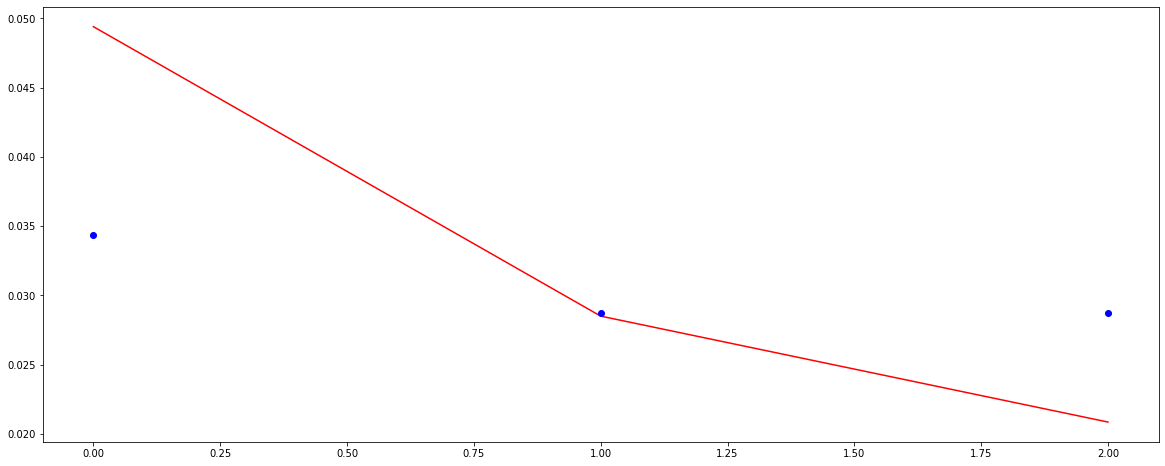

In [51]:
model2 = UrbanGreenRegression()
criterion2 = torch.nn.MSELoss(reduction='mean')
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, 'min', patience=5, factor=0.75)
best_model_path = train_model(model2, Dataloaders_NON_OHE, criterion2, optimizer2, scheduler2, device, num_epochs=3, batch_size=batch_size, path='../Data/N12/Model/Segmentation/Regression/', description='temp')

In [ ]:
class UrbanGreenSegmentation(pl.LightningModule):
    def __init__(self, rotate_training_data : bool = False, train_ratio : float = 0.8, patch_size : int = 100, batch_size : int = 16):
        super(UrbanGreenSegmentation, self).__init__()
        raw_data_array, raw_target_array = prepare_raw_files(one_hot_encode=True)
        _, raw_target_array_Reg = prepare_raw_files(one_hot_encode=False)
        self.batch_size = batch_size
        self.Datasets_Seg = {
            'Train' : TrainDataset2(raw_data_array, raw_target_array, patch_size = patch_size, rotate = rotate_training_data, train_ratio = train_ratio, one_hot_encoding = True),
            'Validation' : TrainDataset2(raw_data_array, raw_target_array, patch_size = patch_size, is_validating = True, rotate = rotate_training_data, train_ratio = train_ratio, one_hot_encoding = True),
            'Prediction' : TrainDataset2(raw_data_array, raw_target_array, patch_size = patch_size, is_evaluating = True, train_ratio = train_ratio, one_hot_encoding = True)
        }
        self.Datasets_Reg = {
            'Train' : TrainDataset2(raw_data_array, raw_target_array_Reg, patch_size = patch_size, rotate = rotate_training_data, train_ratio = train_ratio, one_hot_encode=False),
            'Validation' : TrainDataset2(raw_data_array, raw_target_array_Reg, patch_size = patch_size, is_validating = True, rotate = rotate_training_data, train_ratio = train_ratio, one_hot_encode=False),
            'Prediction' : TrainDataset2(raw_data_array, raw_target_array_Reg, patch_size = patch_size, is_evaluating = True, train_ratio = train_ratio, one_hot_encode=False)
        }
        

        

        


        pass

    def forward(self, x):
        pass

    def training_step(self, batch, batch_idx):
        pass

    def validation_step(self, batch, batch_idx):
        pass

    def predict_step(self, batch, batch_idx):
        pass

    def configure_optimizers(self):
        train_optimizer = torch.optim.Adam(self.parameters(), lr=0.02)
        train_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(train_optimizer, T_max=10)
        return [train_optimizer], [train_scheduler]

    def train_dataloader(self):
        return DataLoader(self.Datasets['Train'], batch_size = self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.Datasets['Validation'], batch_size = self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.Datasets['Prediction'], batch_size = self.batch_size)